# Unsupervised learning on sleep_classifiers output data
This Jupyter Notebook assumes that you have already run Dr. Olivia Walch's <a href="https://github.com/ojwalch/sleep_classifiers">sleep_classifiers</a> preprocessor script, <a href="https://github.com/ojwalch/sleep_classifiers/tree/master/source/preprocessing">preprocessing_runner.py</a>, and that the acceleration data is stored in <code>[jupyter_notebook_root]/data/motion</code>. Change the path in the second box below, otherwise; the data does have to exist within the Jupyter Lab path, though.

We start by using _k_-means and DBSCAN classification with _k_ = 2 (asleep/awake, hopefully!) to have some other unsupervised models to compare with. In the future, we plan to use the well-known "elbow" method for choosing a _k_-value.
    
Please see also:  
__Walch, O.__ (2019). _Motion and heart rate from a wrist-worn wearable and labeled sleep from polysomnography (version 1.0.0)_. PhysioNet. https://doi.org/10.13026/hmhs-py35   
__Walch, O., Huang, Y., Forger, D., Goldstein, C.__ _Sleep stage prediction with raw acceleration and photoplethysmography heart rate data derived from a consumer wearable device_.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sleep, vol. 42, issue 12. https://academic.oup.com/sleep/article/42/12/zsz180/5549536


In [1]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import matplotlib.colors as mplcol
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D

# For comparison with tensorflow
from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
from sklearn.metrics import accuracy_score as jacc 

# Need to have TensorFlow 2.1+ and Keras API installed. 
#!conda install tensorflow keras
#import tensorflow as tf
#from tensorflow import keras

In [2]:
# Load just one of the participant's data.
accel = pd.read_csv("data/motion/5383425_acceleration.txt", sep=' ', names=['time', 'x', 'y', 'z'])
accel = accel.set_index('time') # Allows for intuitive time-based selection of entries using accel.loc[start_time:end_time]

In [3]:
accel_kmeans = KMeans(n_clusters=2) # n_clusters=2, hopefully wake/sleep
accel_kmeans.fit(accel)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [4]:
accel['Wake_Sleep'] = accel_kmeans.labels_ 

In [5]:
colors = plt.cm.Spectral(np.linspace(0, 1, 2))

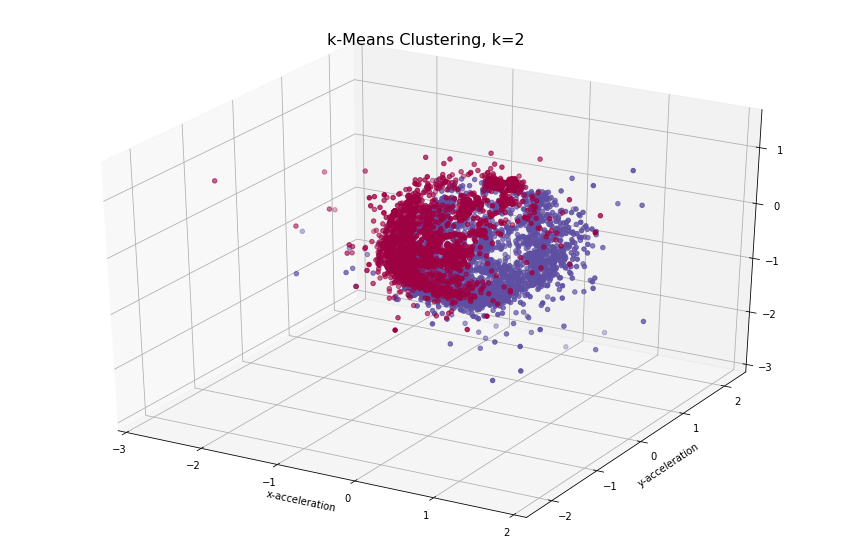

In [6]:
# Uncomment for pop-out window that's interactive. The many data points is pretty punishing to 3d render on my computers, but maybe your GPU is better...
#%matplotlib tk
# Uncomment for inline, non-interactive plotting.
%matplotlib inline 
fig = plt.figure(figsize=(15, 10)) # sometimes figsize prevents matplotlib from opening a GTK window, it seems. Remove figsize if so.
ax = fig.add_subplot(111, projection="3d")

for k, col in zip(range(2), colors):
    cluster = (accel['Wake_Sleep'] == k)
    
    ax.scatter(accel['x'][cluster], accel['y'][cluster], accel['z'][cluster], c=[col])
 
ax.set_title("k-Means Clustering, k=2", fontsize=16)
ax.set_xlabel('x-acceleration')
ax.set_ylabel('y-acceleration')
plt.savefig(fname="2-means.png", format='png')

Let's compare this simple 2-means model with the labeling done during the study. There, 5 categories were recorded during the polysomnography: 0 = awake, and then 1-4 correspond to various stages of sleep. We load the subject's data in, then reduce the classes, then compare accuracy. 

In [7]:
accel_labeled = pd.read_csv("data/labels/5383425_labeled_sleep.txt", sep=' ', names=['time', 'class'])

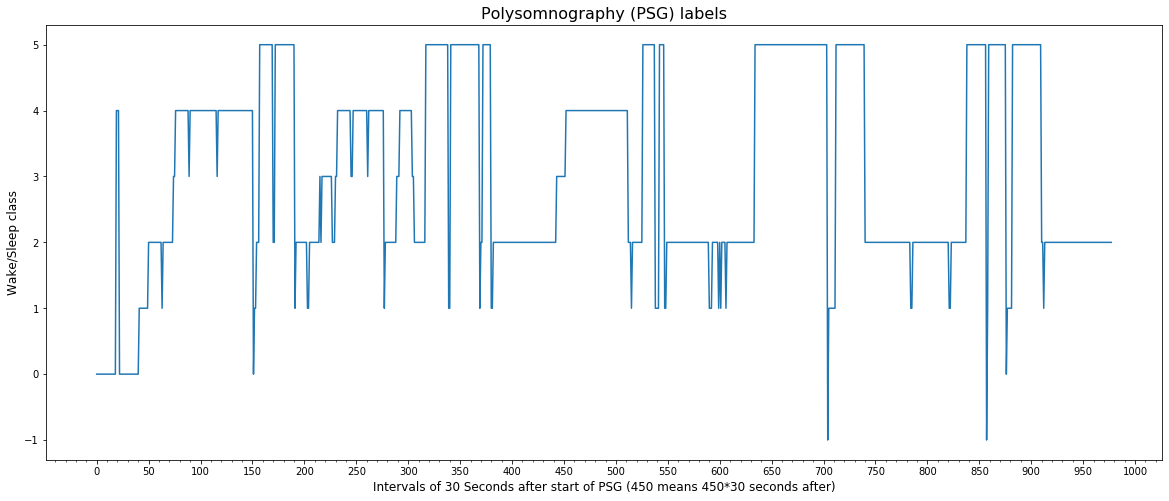

In [8]:
# accel_labeled.head() doesn't give much insight, because there are a lot of records labeled the same in a row.
fig0 = plt.figure(figsize=(20,8))
ax0 = fig0.add_subplot(111)

ax0.plot(accel_labeled['class'])
ax0.set_title("Polysomnography (PSG) labels", fontsize=16)
ax0.set_xlabel("Intervals of 30 Seconds after start of PSG (450 means 450*30 seconds after)",fontsize=12)
ax0.set_ylabel("Wake/Sleep class", fontsize=12)
ax0.xaxis.set_major_locator(MultipleLocator(50))
ax0.xaxis.set_minor_locator(MultipleLocator(10))

We see there are two records with a label of "-1". Let's drop those for now...

In [9]:
accel_labeled[accel_labeled['class'] == -1]

,time,class
704,21120,-1
857,25710,-1


In [10]:
accel_pos_lab = accel_labeled.drop(labels=[704, 857], axis=0)

In [11]:
accel_pos_lab['Wake_Sleep'] = accel_pos_lab['class'].apply(lambda x: 0 if (x == 0) else 1)

Our <code>accel</code> DataFrame has many more data points than <code>accel_pos_lab</code>, since the latter only has a sample every 30 seconds. In order to be able to evaluate the accuracy of our model, we're going to need to collapse/downsample the predictions. The two methods we'll explore are: take a majority vote over 30 second intervals, and take the average prediction (rounded to 0/1, with 0.5 ~> 1). We'll also keep track of the average _x, y,_ and _z_-accelerations over these intervals, too.

In [12]:
downsample_list = []
for j in range(int(accel.tail(1).index[0]/30)):
    sample = accel.loc[30*j:30*(j+1)-0.1] # 0.1 is around the average time separation between samples in accel. DataFrame slices are inclusive.
    downsample_list.append((30*j, 
                            sample['Wake_Sleep'].mode()[0], 
                            min(int(sample['Wake_Sleep'].mean()/0.5), 1), # There are some intervals with a mean of 1.
                            sample['x'].mean(), sample['y'].mean(), sample['z'].mean()
                           ))

In [13]:
len(downsample_list)

992

In [14]:
downsample_df = pd.DataFrame([d[1:] for d in downsample_list], index = [d[0] for d in downsample_list], columns = ('Majority', 'Average', 'x', 'y', 'z'))

In [15]:
downsample_df[downsample_df['Majority'] != downsample_df['Average']]

,Majority,Average,x,y,z


So it seems majority and average voting gives the same outcome. 

In [16]:
accel_pos_lab.set_index('time', inplace=True)

In [17]:
accel_pos_lab.tail(1)

,class,Wake_Sleep
time,,
29310,2,1


In [18]:
downsample_df = downsample_df.loc[:29310]
downsample_df.drop(labels=[21120, 25710], axis=0, inplace=True)

In [19]:
jacc(downsample_df['Majority'], accel_pos_lab['Wake_Sleep'])

0.5450819672131147

That's really not very good. Let's make two plots, one showing the PSG labeling and the other showing our _k_-means clustering.

In [20]:
accel_pos_lab.index

Int64Index([    0,    30,    60,    90,   120,   150,   180,   210,   240,
              270,
            ...
            29040, 29070, 29100, 29130, 29160, 29190, 29220, 29250, 29280,
            29310],
           dtype='int64', name='time', length=976)

In [21]:
downsample_df.index

Int64Index([    0,    30,    60,    90,   120,   150,   180,   210,   240,
              270,
            ...
            29040, 29070, 29100, 29130, 29160, 29190, 29220, 29250, 29280,
            29310],
           dtype='int64', length=976)

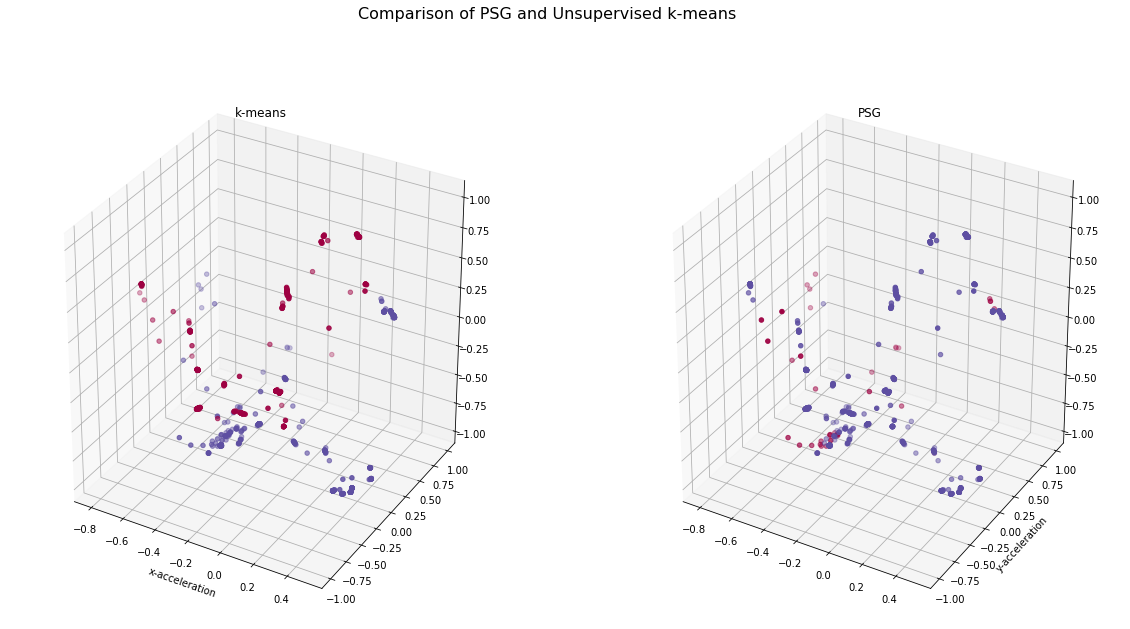

In [38]:
fig_cmp = plt.figure(figsize=(20, 10))
ax0 = fig_cmp.add_subplot(1,2,1, projection="3d")
ax1 = fig_cmp.add_subplot(1,2,2, projection="3d")

for k, color in zip(range(2), colors):
    cluster0 = (downsample_df['Majority'] == k)
    cluster1 = (accel_pos_lab['Wake_Sleep'] == k)
    
    ax0.scatter(downsample_df[cluster0]['x'], downsample_df[cluster0]['y'], downsample_df[cluster0]['z'], c=[color])
    ax1.scatter(downsample_df[cluster1]['x'], downsample_df[cluster1]['y'], downsample_df[cluster1]['z'], c=[color])
    
ax0.set_xlabel('x-acceleration')
ax1.set_ylabel('y-acceleration')
ax0.set_title('k-means')
ax1.set_title('PSG')

fig_cmp.suptitle('Comparison of PSG and Unsupervised k-means', fontsize=16)
plt.savefig("Comparison.png")

## OPTICS
This is a clustering technique more suitable for large data sets than the current sklearn implementation of DBSCAN. While OPTICS has quadratic time complexity (in number of records), it has linear space complexity since the entire distance matrix is not stored in memory, only one row of this. 

In [34]:
accel.drop(labels=["Wake_Sleep"], axis=1, inplace=True)

In [35]:
accel.head()

,x,y,z
time,,,
-23.923694,-0.120010,-0.636520,-0.728577
-23.827496,-0.122360,-0.653198,-0.735413
-23.742329,-0.114426,-0.642441,-0.744125
-23.642581,-0.117386,-0.652725,-0.741196
-23.542767,-0.114456,-0.654175,-0.737213


In [39]:
clusts = OPTICS(min_samples = 20, max_eps = 0.4, cluster_method='xi')

In [40]:
%time clusts.fit(accel)

CPU times: user 29min 44s, sys: 1.28 s, total: 29min 45s
Wall time: 29min 45s


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=0.4, metric='minkowski', metric_params=None,
       min_cluster_size=None, min_samples=20, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)

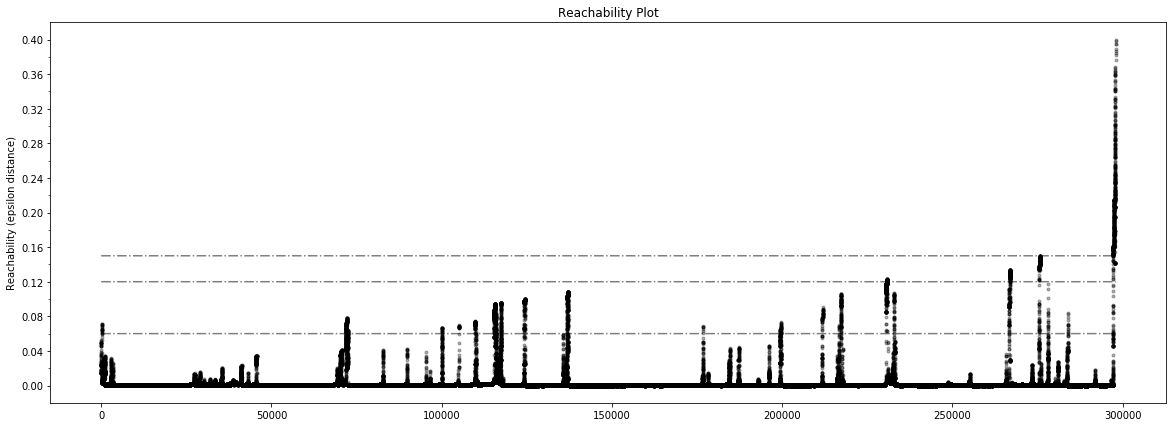

In [41]:
space = np.arange(len(accel))
reachability = clusts.reachability_[clusts.ordering_]
labels = clusts.labels_[clusts.ordering_]

fig = plt.figure(figsize=(20, 7))
ax1 = fig.add_subplot(111)

# Reachability plot
ax1.plot(space, reachability, 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 0.06, dtype=float), 'k-.', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.12, dtype=float), 'k-.', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.15, dtype=float), 'k-.', alpha=0.5)

ax1.yaxis.set_major_locator(MultipleLocator(0.04))
ax1.yaxis.set_minor_locator(MultipleLocator(0.02))
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')
plt.savefig(fname="OPTICS Reachability.png", format='png')

In [42]:
%time # DBSCAN is much faster now!
dbscan_006 = cluster_optics_dbscan(reachability=clusts.reachability_, core_distances=clusts.core_distances_, ordering=clusts.ordering_, eps=0.06)
dbscan_012 = cluster_optics_dbscan(reachability=clusts.reachability_, core_distances=clusts.core_distances_, ordering=clusts.ordering_, eps=0.12)
dbscan_015 = cluster_optics_dbscan(reachability=clusts.reachability_, core_distances=clusts.core_distances_, ordering=clusts.ordering_, eps=0.15)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


In [43]:
print("Number of clusters for varying epsilon:\n{:>10} : {:>10}\n{:>10} : {:>10}\n{:>10} : {:>10}\n".format(0.06, len(dbscan_006), 0.12, len(set(dbscan_012)), 0.15, len(set(dbscan_015))))

Number of clusters for varying epsilon:
      0.06 :     298000
      0.12 :          7
      0.15 :          4



In [44]:
%matplotlib inline

In [46]:
colors

array([[0.61960784, 0.00392157, 0.25882353, 1.        ],
       [0.99346405, 0.74771242, 0.43529412, 1.        ],
       [0.74771242, 0.89803922, 0.62745098, 1.        ],
       [0.36862745, 0.30980392, 0.63529412, 1.        ]])

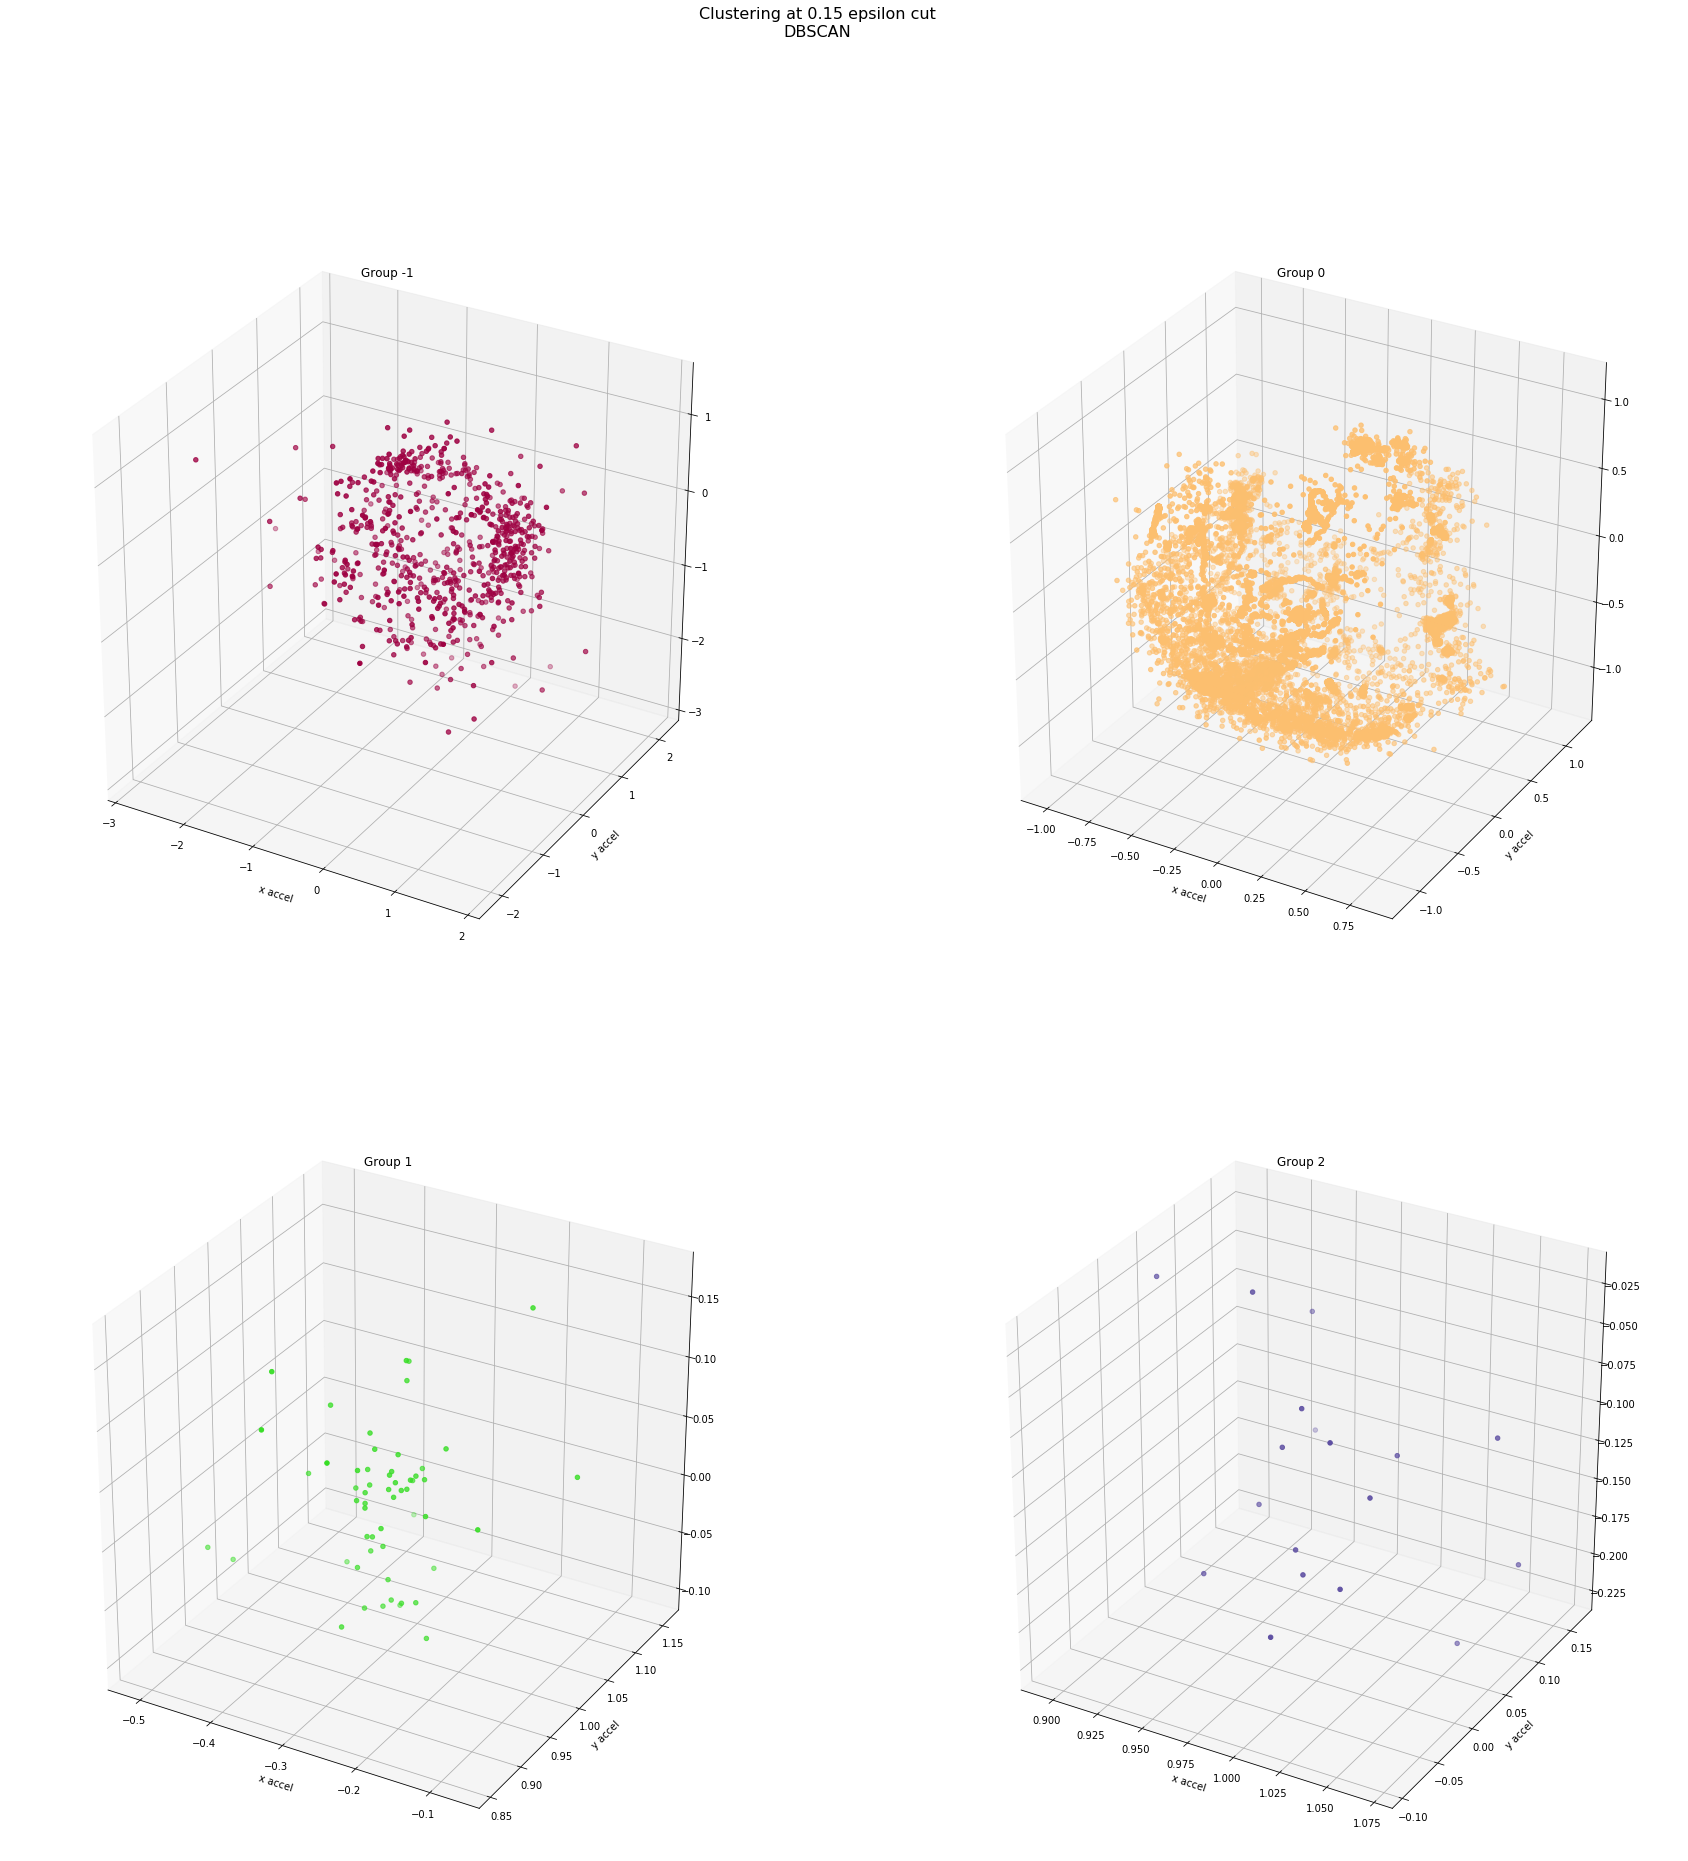

In [48]:
fig3d = plt.figure(figsize=(30,30))
groups = []

# DBSCAN at eps = 0.15
colors = plt.cm.Spectral(np.linspace(0,1,4))
colors[2] = [(56/255), (222/255), (38/255), 1.]# 56, 222, 38
for k, color in zip(range(-1, 3), colors):
    groups.append(fig3d.add_subplot(2,2,k+2, projection="3d"))
    acc_k = accel[dbscan_015 == k]
    groups[-1].scatter(acc_k['x'], acc_k['y'], acc_k['z'], c=[color])
    groups[-1].set_title('Group {}'.format(k))
    groups[-1].set_xlabel('x accel')
    groups[-1].set_ylabel('y accel')

fig3d.suptitle('Clustering at 0.15 epsilon cut\nDBSCAN', fontsize=16)
plt.savefig("DBSCAN_015.png")